In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import deeplabv3_resnet50
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.coco = COCO(annotations_path)
        self.img_ids = self.coco.getImgIds()
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.images_path, img_info['file_name'])

        img = np.array(Image.open(img_path).convert("RGB"))
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        for ann in anns:
            m = self.coco.annToMask(ann)
            mask = np.maximum(mask, m)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        return img, mask.long()


In [3]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [4]:
images_path = r"D:\val2017\val2017"
annotations_path = r"D:\annotations_trainval2017\annotations\instances_val2017.json"

dataset = CocoMaskedDataset(images_path, annotations_path, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


loading annotations into memory...
Done (t=1.67s)
creating index...
index created!


In [5]:
model = deeplabv3_resnet50(weights=None, aux_loss=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)  # 2 classes (background + object)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [6]:
def train_model(model, train_loader, val_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return model

In [7]:
if not os.path.exists("deeplabv3_hand_segmentation.pth"):
    trained_model = train_model(model, train_loader, val_loader, num_epochs=5)
    torch.save(trained_model.state_dict(), "deeplabv3_hand_segmentation.pth")
    print("Model saved as deeplabv3_hand_segmentation.pth")
else:
    print("Using pre-trained checkpoint")

model = deeplabv3_resnet50(weights=None, aux_loss=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
state_dict = torch.load("deeplabv3_hand_segmentation.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()
print("Model reloaded successfully!")


Using pre-trained checkpoint
Model reloaded successfully!


In [8]:
def iou_score(preds, masks, num_classes=2):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())
    return np.nanmean(ious)

def dice_score(preds, masks, num_classes=2):
    preds = torch.argmax(preds, dim=1)
    dices = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().float() * 2.0
        denominator = pred_inds.sum().float() + target_inds.sum().float()
        if denominator == 0:
            dices.append(float('nan'))
        else:
            dices.append((intersection / denominator).item())
    return np.nanmean(dices)

def pixel_accuracy(preds, masks):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == masks).sum().float()
    total = torch.numel(masks)
    return (correct / total).item()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151553..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


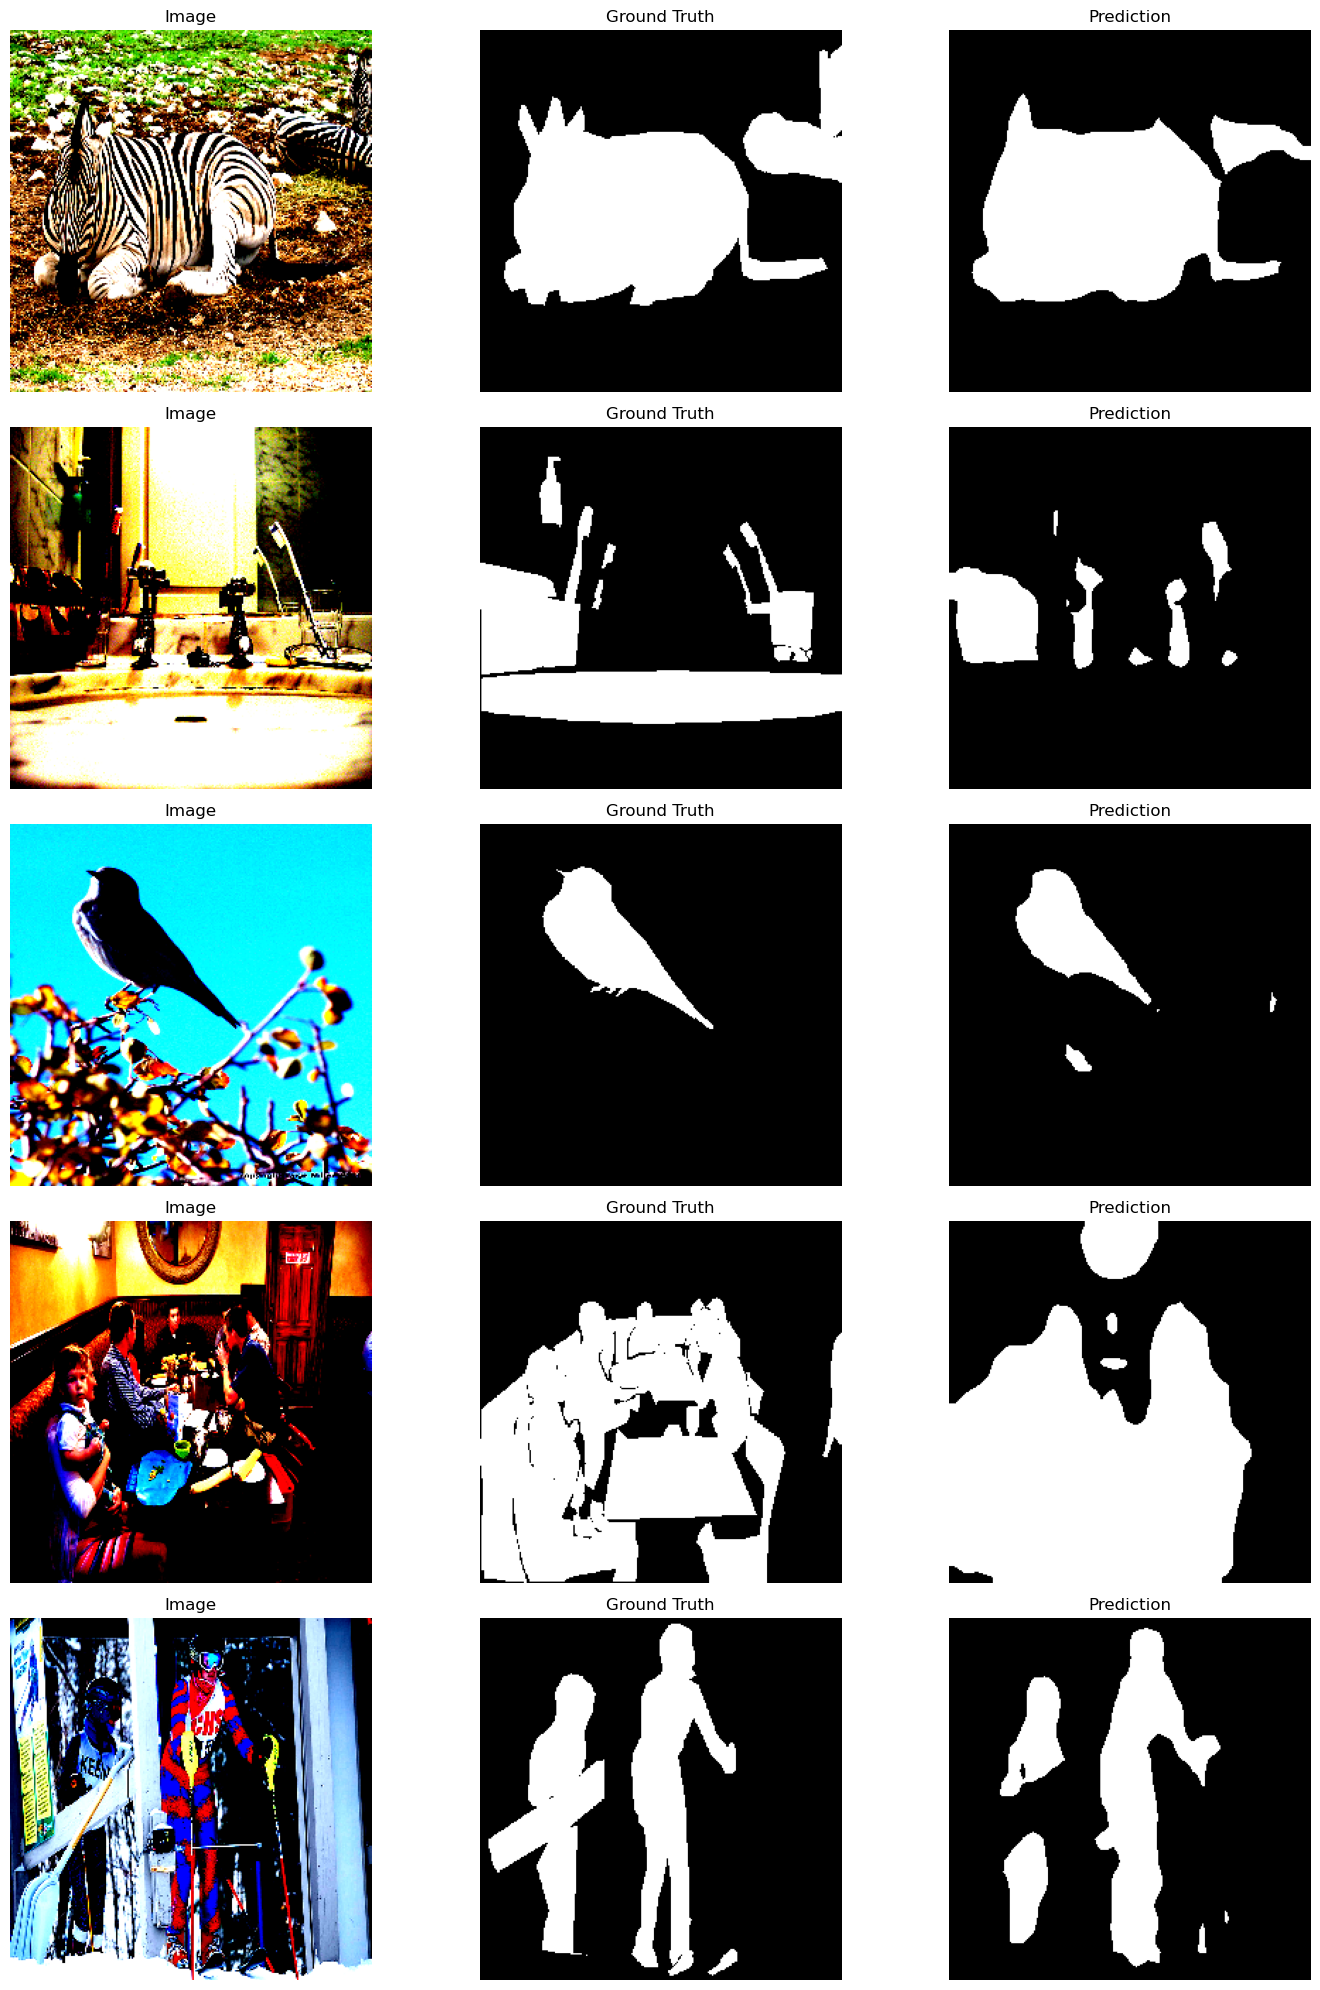

In [9]:
def visualize_predictions(model, dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)
    plt.figure(figsize=(15, num_samples*4))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_np = img.permute(1,2,0).cpu().numpy()
        mask_np = mask.cpu().numpy()

        img_input = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_input)["out"]
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        # Plot original, GT mask, prediction
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_np)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset, num_samples=5)


In [10]:
val_dataset_eval = CocoMaskedDataset(images_path, annotations_path, transform=val_transform)
val_loader_eval = DataLoader(val_dataset_eval, batch_size=4, shuffle=False)

metrics = {"IoU": [], "Dice": [], "PixelAcc": []}

model.eval()
with torch.no_grad():
    for imgs, masks in tqdm(val_loader_eval, desc="Evaluating"):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)["out"]

        metrics["IoU"].append(iou_score(outputs, masks))
        metrics["Dice"].append(dice_score(outputs, masks))
        metrics["PixelAcc"].append(pixel_accuracy(outputs, masks))

print(f"Mean IoU: {np.mean(metrics['IoU']):.4f}")
print(f"Mean Dice: {np.mean(metrics['Dice']):.4f}")
print(f"Pixel Accuracy: {np.mean(metrics['PixelAcc']):.4f}")


loading annotations into memory...
Done (t=10.62s)
creating index...
index created!


Evaluating: 100%|████████████████████████████████████████████████████████████████| 1250/1250 [1:33:56<00:00,  4.51s/it]

Mean IoU: 0.7314
Mean Dice: 0.8340
Pixel Accuracy: 0.8719
